This notebook analyzes a comprehensive frame-level dataset (dataset.csv) containing runtime and quality metrics extracted from four large vision-language models (VLMs) — Qwen2.5-VL, LLaVA, InstructBLIP, and DeepSeek-VL — across surveillance video categories. Each video is processed under three levels of prompt difficulty (easy, medium, hard) to evaluate prompt sensitivity.

For every sampled frame (typically 1 per second), the following key metrics were logged:

	•	Inference latency (Inference Time (ms))
	•	Hardware utilization (GPU Usage (%), VRAM (MB), Power (W))
	•	Model response quality (Confidence)

This analysis uses the full dataset — all classes, all prompt levels, all videos, to assess how models behave in terms of efficiency and performance across time (frames) and tasks.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import griddata
import seaborn as sns

# Load unified dataset
df = pd.read_csv("dataset.csv")

# Ensure data types
df["Frame"] = df["Frame"].astype(int)
df["Confidence"] = df["Confidence"].astype(float)
df["Power (W)"] = df["Power (W)"].astype(float)
df["Inference Time (ms)"] = df["Inference Time (ms)"].astype(float)
df["GPU Usage (%)"] = df["GPU Usage (%)"].astype(float)
df["VRAM (MB)"] = df["VRAM (MB)"].astype(float)

# Map model names to numeric IDs
model_to_id = {name: idx for idx, name in enumerate(df["Model"].unique())}
df["Model_ID"] = df["Model"].map(model_to_id)

/tmp/ipykernel_762491/1230117997.py:66: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


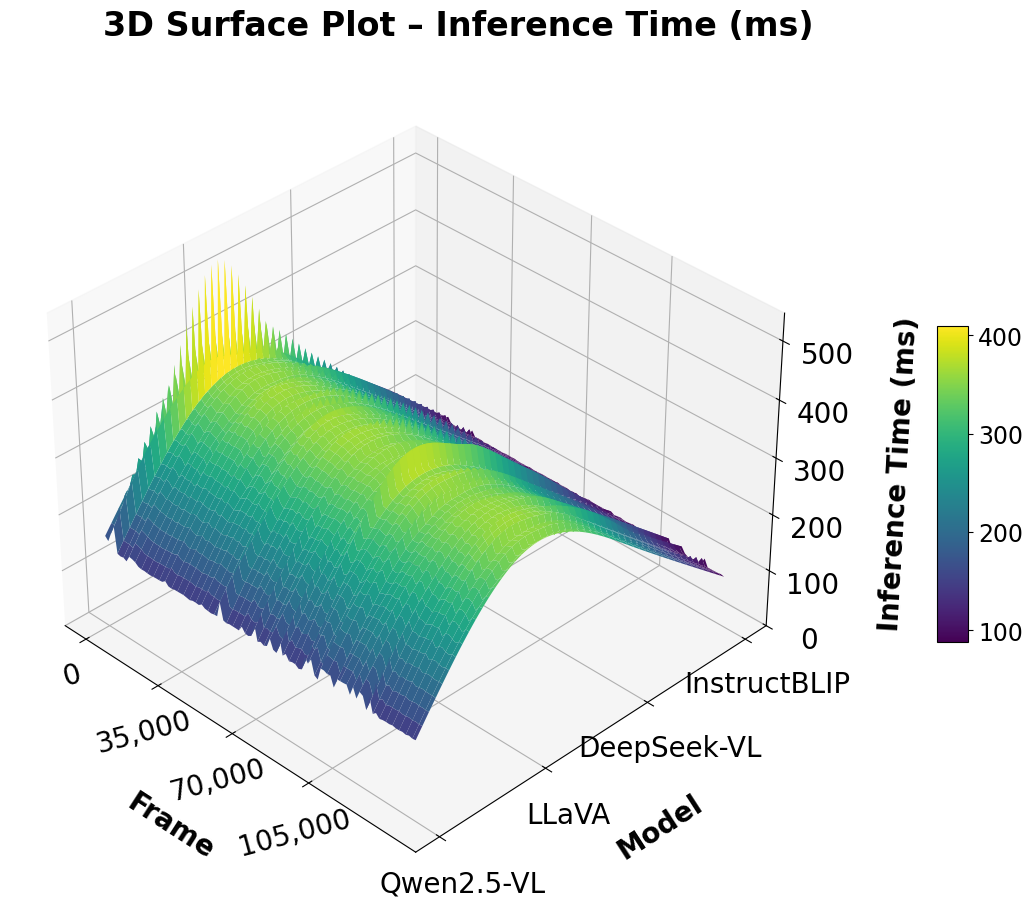

/tmp/ipykernel_762491/1230117997.py:66: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


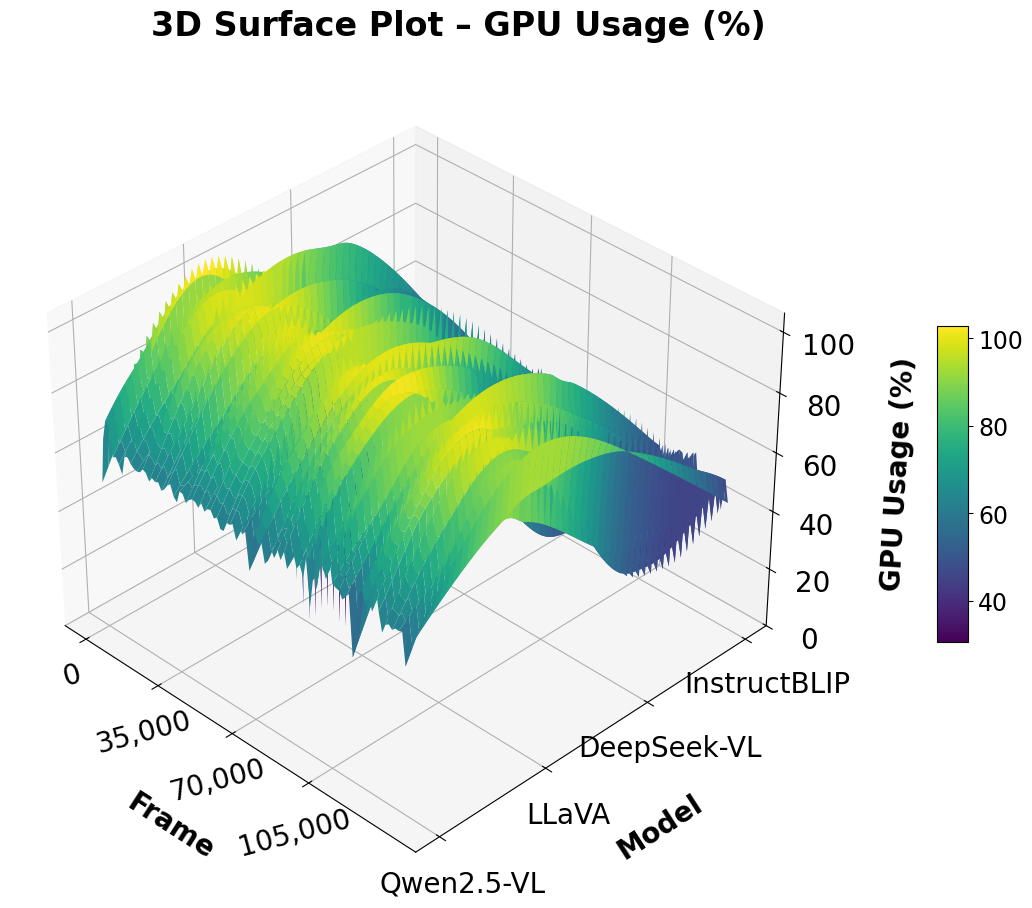

/tmp/ipykernel_762491/1230117997.py:66: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


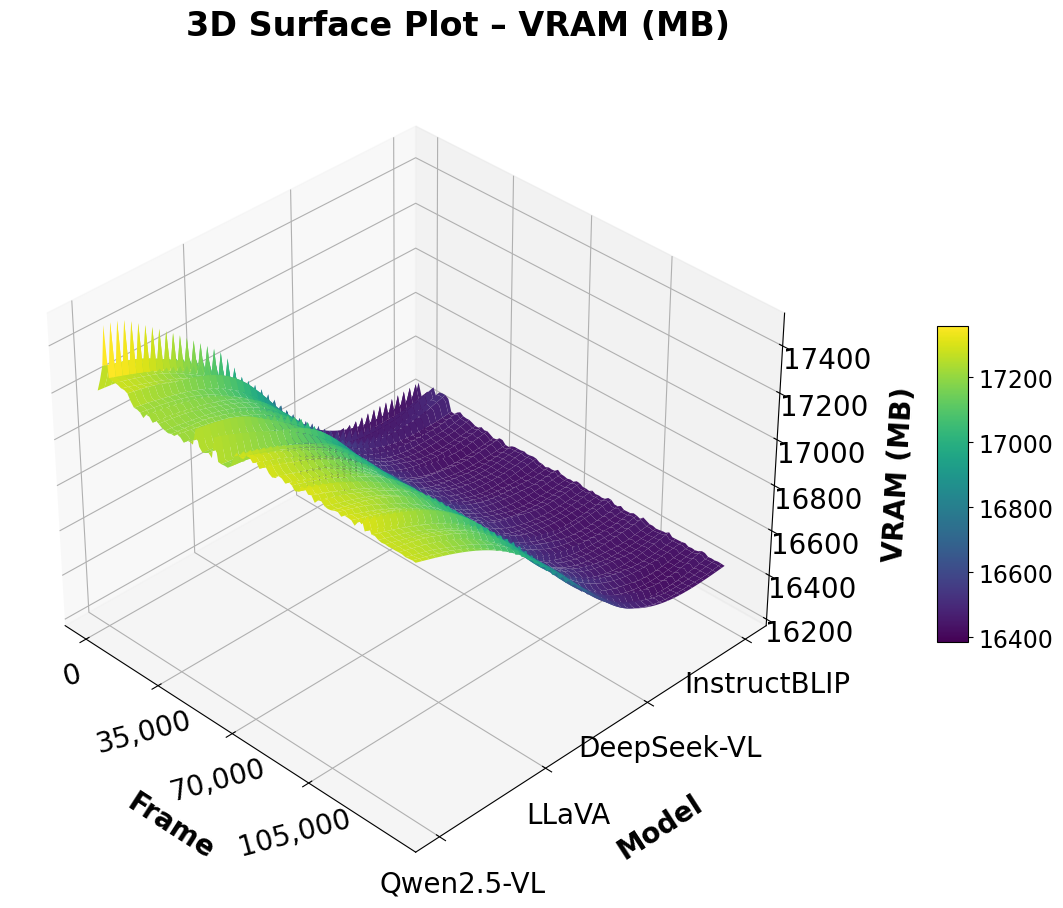

/tmp/ipykernel_762491/1230117997.py:66: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


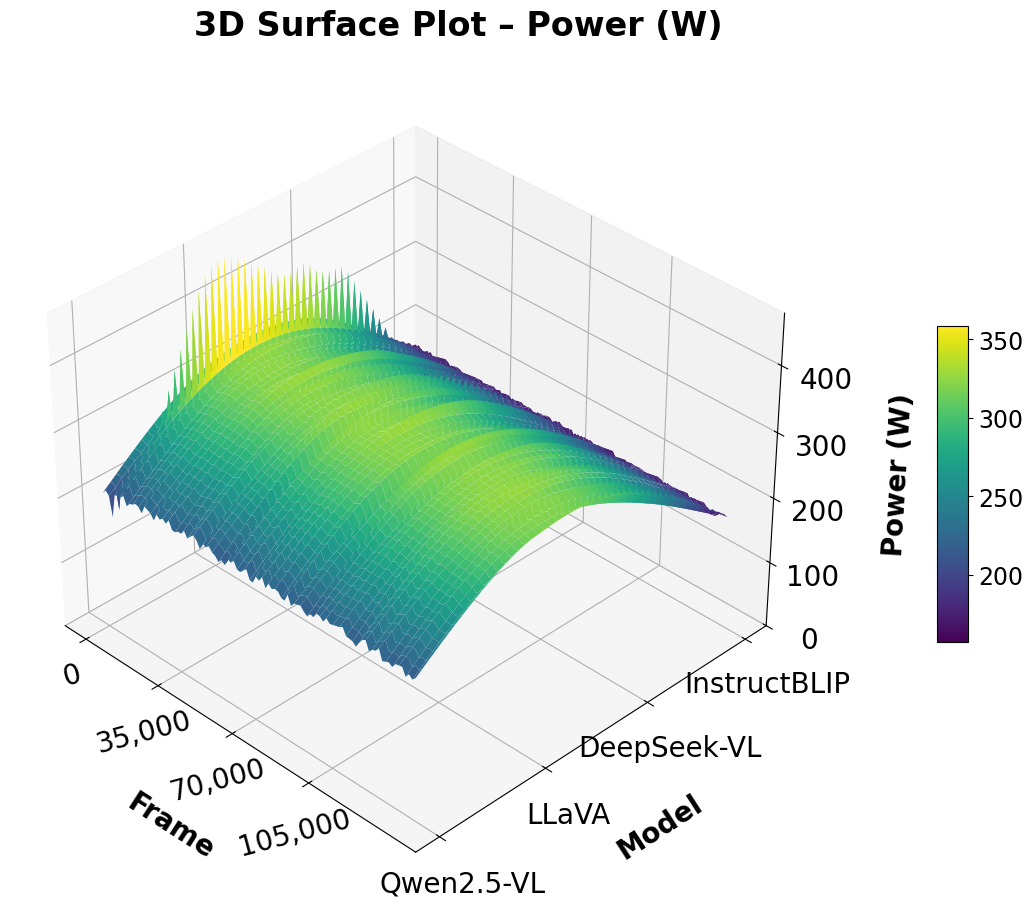

/tmp/ipykernel_762491/1230117997.py:66: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


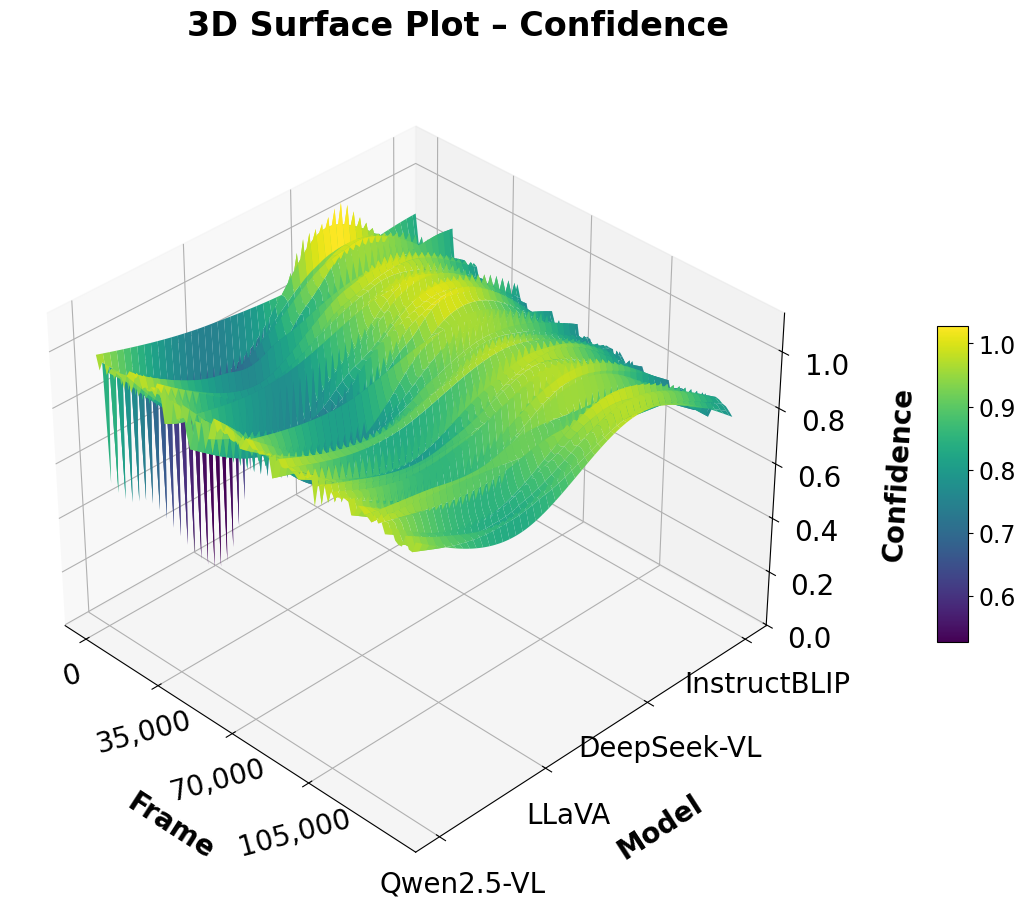

In [4]:
# Surface plot for each metric
metrics = {
    "Inference Time (ms)": "Inference Time (ms)",
    "GPU Usage (%)": "GPU Usage (%)",
    "VRAM (MB)": "VRAM (MB)",
    "Power (W)": "Power (W)",
    "Confidence": "Confidence"
}

for metric, label in metrics.items():
    if metric not in df.columns:
        continue

    # Interpolation
    grid_x, grid_y = np.meshgrid(
        np.linspace(df["Frame"].min(), df["Frame"].max(), 100),
        np.linspace(0, len(model_to_id) - 1, 100)
    )
    points = df[["Frame", "Model_ID"]].values
    values = df[metric].values
    grid_z = griddata(points, values, (grid_x, grid_y), method="cubic")

    # Define frame axis limits
    frame_min = int(df["Frame"].min())
    frame_max = int(df["Frame"].max())
    frame_step = 35000
    xticks = np.arange(0, frame_max - 10000, frame_step)  # avoid final tick overlap

    # Plot setup
    fig = plt.figure(figsize=(18, 10))
    ax = fig.add_subplot(111, projection="3d")
    ax.view_init(elev=35, azim=-45)

    # Surface
    surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap=cm.viridis, linewidth=0, antialiased=True)

    # Labels
    ax.set_xlabel("Frame", fontsize=20, labelpad=30, weight='bold')
    ax.set_ylabel("Model", fontsize=20, labelpad=30, weight='bold')
    ax.set_zlabel(label, fontsize=20, labelpad=30, weight='bold')

    # Ticks
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{x:,}" for x in xticks], fontsize=20)
    ax.set_yticks(list(model_to_id.values()))
    ax.set_yticklabels(list(model_to_id.keys()), fontsize=20)
    ax.yaxis.set_tick_params(pad=10)
    ax.tick_params(axis='z', labelsize=20)
    ax.zaxis.set_tick_params(pad=10)

    for t in ax.get_xticklabels():
        t.set_rotation(15)

    # Smart Z-limits
    if metric not in ["Confidence", "VRAM (MB)"]:
        ax.set_zlim(0, np.nanmax(grid_z))

    # Colorbar
    cbar = fig.colorbar(surf, ax=ax, shrink=0.4, aspect=10, pad=0.1)
    cbar.ax.tick_params(labelsize=17)

    # Centered global title
    fig.suptitle(f"3D Surface Plot – {label}", fontsize=24, y=0.98, weight='bold')

    # Adjust layout to prevent clipping and center content
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, left=0.12, right=0.88)

    # Save to PDF
    fig.savefig(f"3d_surface_{metric.lower().replace(' ', '_').replace('(', '').replace(')', '')}.pdf", format='pdf', bbox_inches='tight')

    plt.show()

This plot presents a 3D surface visualization of metric variation across all frames and models. It captures how each metric evolves across the dataset, using:

	•	X-axis: Global frame index across all videos and prompts (linear accumulation, not per-video time).
	•	Y-axis: Model identifier (Qwen2.5-VL, LLaVA, InstructBLIP, DeepSeek-VL).
	•	Z-axis: Metric value (e.g., inference time, GPU usage, etc.).
    •	Color: Encodes the magnitude of the metric.

This view helps identify system-level patterns across the entire benchmark:

	•	Consistency or variability in runtime,
	•	Model-specific performance drifts,
	•	Outliers or spikes caused by certain videos or prompts.
	

Note: This is not a per-video timeline. The X-axis captures frame samples in total dataset order (repeated videos included under different prompts), giving a distributional view, not a chronological one.

-----------

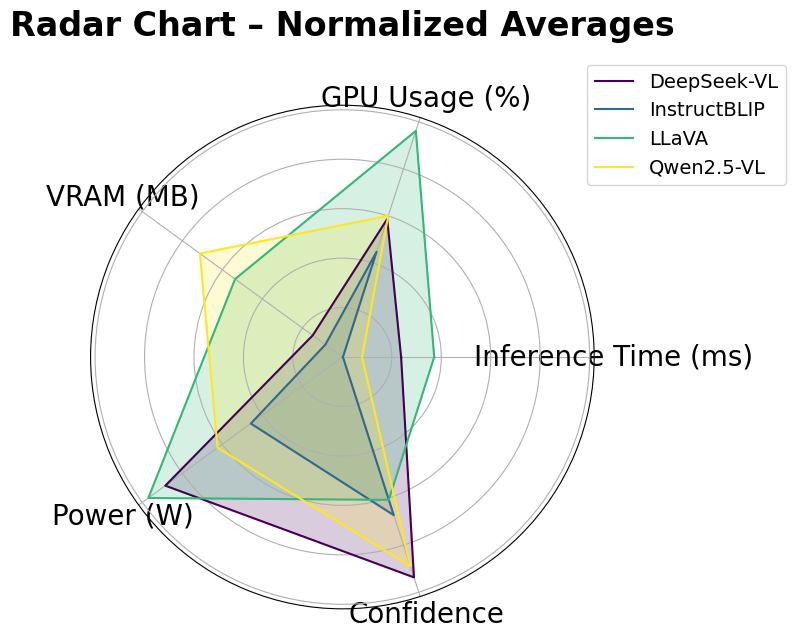

In [12]:
# Normalize metrics
metrics_list = ["Inference Time (ms)", "GPU Usage (%)", "VRAM (MB)", "Power (W)", "Confidence"]
normalized = df.copy()
for metric in metrics_list:
    min_val = normalized[metric].min()
    max_val = normalized[metric].max()
    normalized[metric] = (normalized[metric] - min_val) / (max_val - min_val)

# Average per model
mean_metrics = normalized.groupby("Model")[metrics_list].mean()

# Radar plot
labels = metrics_list
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist() + [0]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
colors = plt.cm.viridis(np.linspace(0, 1, len(mean_metrics)))

for idx, (model, row) in enumerate(mean_metrics.iterrows()):
    values = row.tolist() + [row.tolist()[0]]
    ax.plot(angles, values, label=model, color=colors[idx])
    ax.fill(angles, values, alpha=0.2, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=20) 
ax.set_yticklabels([])
ax.set_title("Radar Chart – Normalized Averages", pad=50, fontsize=24, weight='bold')
ax.legend(loc="upper right", bbox_to_anchor=(1.4, 1.1), fontsize=14)
plt.tight_layout()
plt.savefig("radar_chart.pdf")  # Save as PDF
plt.show()



This radar chart provides a comparative fingerprint of the four models across all key metrics, after applying min-max normalization:

	•	All metrics are scaled to [0, 1] to make them comparable despite unit differences.
	•	Each axis of the radar corresponds to one metric.
	•	The shape of each model’s polygon reveals strengths and weaknesses (e.g., one may have high confidence but high power usage).

This visualization supports qualitative comparisons of model trade-offs, allowing intuitive interpretation of efficiency vs accuracy.

------------------------------------------------------------------

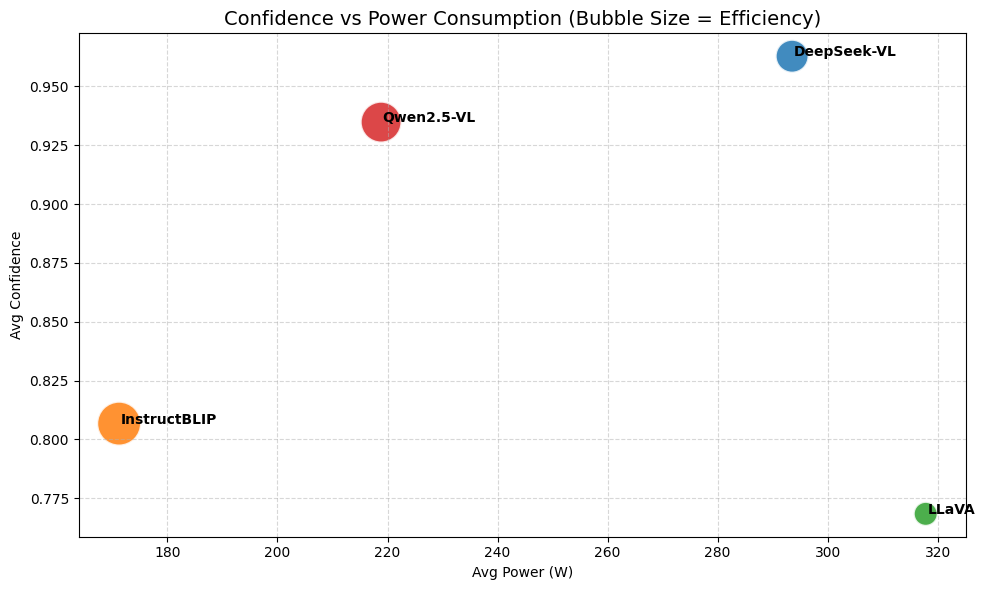

In [10]:
# Compute Confidence per Watt
df["Confidence/W"] = df["Confidence"] / df["Power (W)"]

# Aggregate
agg = df.groupby("Model").agg({
    "Confidence": "mean",
    "Power (W)": "mean",
    "Confidence/W": "mean"
}).reset_index()

# Bubble plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=agg,
    x="Power (W)",
    y="Confidence",
    size="Confidence/W",
    hue="Model",
    palette="tab10",
    sizes=(300, 1000),
    legend=False,
    alpha=0.85
)

for _, row in agg.iterrows():
    plt.text(row["Power (W)"] + 0.3, row["Confidence"], row["Model"], fontsize=10, weight="bold")

plt.title("Confidence vs Power Consumption (Bubble Size = Efficiency)", fontsize=14)
plt.xlabel("Avg Power (W)")
plt.ylabel("Avg Confidence")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

This final visualization compares average model confidence to average power consumption, with bubble size encoding efficiency (Confidence / Power).

	•	X-axis: Average power usage.
	•	Y-axis: Average confidence score.
	•	Bubble size: Confidence per watt.

This lets you directly reason about cost-performance tradeoffs, identifying models that achieve high certainty at lower energy costs — critical for real-time or embedded systems.

------------------------------------------------------------------

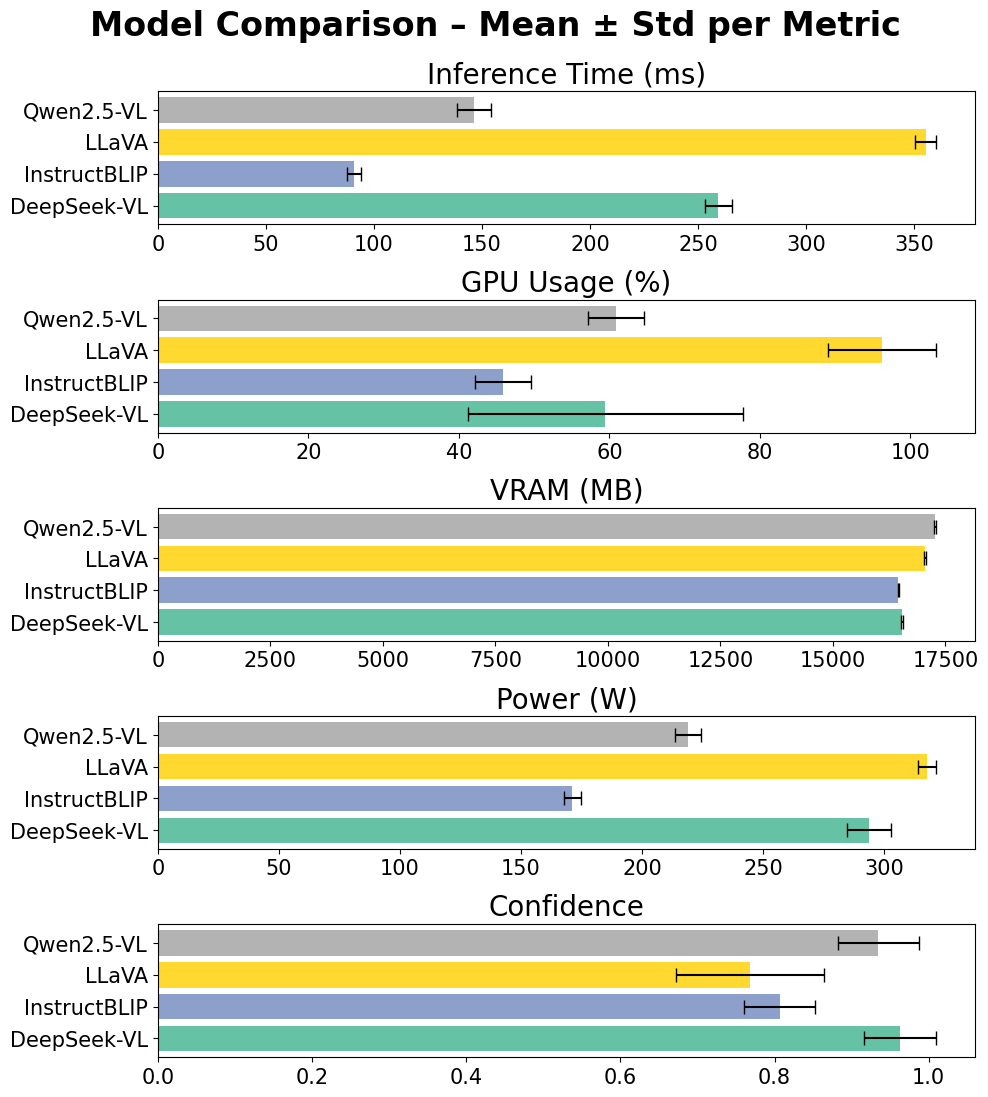

In [9]:
# Metrics to include
metrics = ["Inference Time (ms)", "GPU Usage (%)", "VRAM (MB)", "Power (W)", "Confidence"]

# Aggregate mean and std
summary = df.groupby("Model")[metrics].agg(["mean", "std"]).reset_index()

# Flatten columns
summary.columns = ["Model"] + [f"{m} {s}" for m in metrics for s in ["mean", "std"]]

# Plot
n_metrics = len(metrics)
fig, axes = plt.subplots(nrows=n_metrics, figsize=(10, 2.3 * n_metrics), sharex=False)
fig.suptitle("Model Comparison – Mean ± Std per Metric", fontsize=24, weight='bold', y=0.95)

colors = plt.cm.Set2(np.linspace(0, 1, len(summary)))

for i, metric in enumerate(metrics):
    ax = axes[i]
    means = summary[f"{metric} mean"]
    stds = summary[f"{metric} std"]
    models = summary["Model"]

    ax.barh(models, means, xerr=stds, color=colors, capsize=5)
    ax.set_title(metric, fontsize=20)
    ax.tick_params(axis='y', labelsize=15)  # Increase number as needed
    ax.tick_params(axis='x', labelsize=15)  # Increase number as needed
    ax.set_xlabel("")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Here, each metric is summarized by its mean and standard deviation per model, displayed using horizontal bar plots.

	•	Each subplot focuses on a different metric.
	•	The bars represent mean values; error bars show standard deviation.
	•	This provides a statistical summary of model performance across all videos, highlighting consistency or volatility in outputs.

It’s particularly useful to assess whether a model consistently performs well or exhibits high variance (e.g., unstable power usage or confidence).


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<br>

<br>

<br>


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<br>

<br>                                                            Time

<br>

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
<br>

<br>

<br>

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [2]:
import os
import cv2
from collections import defaultdict

def get_video_duration(path):
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        print(f"Warning: Failed to open {path}")
        return 0
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    cap.release()
    if fps == 0:
        return 0
    return frame_count / fps  # in seconds

def compute_durations_per_category(base_dir="Videos"):
    category_durations = defaultdict(float)

    for category in os.listdir(base_dir):
        category_path = os.path.join(base_dir, category)
        if not os.path.isdir(category_path):
            continue

        for file in os.listdir(category_path):
            if file.lower().endswith(('.mp4', '.avi', '.mov', '.mkv')):
                video_path = os.path.join(category_path, file)
                duration_seconds = get_video_duration(video_path)
                category_durations[category] += duration_seconds

    return {cat: secs / 60 for cat, secs in category_durations.items()}  # convert to minutes

if __name__ == "__main__":
    durations = compute_durations_per_category("Videos")
    for category, minutes in sorted(durations.items()):
        print(f"{category}: {minutes:.2f} minutes")

Abuse: 107.50 minutes
Arrest: 165.22 minutes
Arson: 151.06 minutes
Assault: 72.19 minutes
Burglary: 261.78 minutes
Explosion: 140.22 minutes
Fighting: 143.83 minutes
RoadAccidents: 144.93 minutes
Robbery: 234.77 minutes
Shooting: 81.93 minutes
Shoplifting: 180.20 minutes
Stealing: 259.68 minutes
Vandalism: 81.76 minutes
z_Normal_Videos: 81.09 minutes


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<br>

<br>

<br>


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<br>

<br>                                                            Flesch-Kincaid

<br>

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
<br>

<br>

<br>

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [1]:
import re

def flesch_kincaid_approx(text):
    words = re.findall(r'\w+', text)
    num_words = len(words)
    num_sentences = text.count('.') + text.count('?') + text.count('!')
    syllables = sum(len(re.findall(r'[aeiouy]+', word.lower())) for word in words)

    if num_sentences == 0 or num_words == 0:
        return 0.0

    ASL = num_words / num_sentences  # Average Sentence Length
    ASW = syllables / num_words      # Average Syllables per Word

    # Flesch-Kincaid Grade Level formula
    return round(0.39 * ASL + 11.8 * ASW - 15.59, 2)

# Define your prompt templates
prompt_templates = {
    "easy":   "Do you see an act of {category} in the frame? Answer Yes or No.",
    "medium": "Does the frame show something that could be interpreted as an instance of {category}? Answer Yes or No.",
    "hard":   "Could a human observer reasonably conclude that this frame depicts {category}-like behavior or consequences? Answer Yes or No."
}

# Use a test category like "fighting"
category = "fighting"

# Compute readability scores
readability_scores = {
    level: flesch_kincaid_approx(template.format(category=category))
    for level, template in prompt_templates.items()
}

# Print results
for level, score in readability_scores.items():
    print(f"{level.capitalize()} prompt: Grade {score}")

Easy prompt: Grade 1.47
Medium prompt: Grade 6.28
Hard prompt: Grade 11.09


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<br>

<br>

<br>


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<br>

<br>                                                            Analyses Time

<br>

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
<br>

<br>

<br>

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("dataset.csv")  # Make sure this path is correct

# Ensure correct column names (case-sensitive)
required_columns = {"Model", "category", "difficulty", "Inference Time (ms)"}
missing = required_columns - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns in CSV: {missing}")

# Group by model, category, and difficulty, and sum the inference time
agg_df = (
    df.groupby(["Model", "category", "difficulty"])["Inference Time (ms)"]
    .sum()
    .reset_index()
)

# Convert ms → minutes
agg_df["Inference Time (minutes)"] = agg_df["Inference Time (ms)"] / 1000 / 60

# Optional: round for display
agg_df["Inference Time (minutes)"] = agg_df["Inference Time (minutes)"].round(2)

# Print the summary
print(agg_df[["Model", "category", "difficulty", "Inference Time (minutes)"]])

# Optionally save to CSV
agg_df.to_csv("total_inference_times.csv", index=False)

           Model         category difficulty  Inference Time (minutes)
0    DeepSeek-VL            Abuse       easy                     29.35
1    DeepSeek-VL            Abuse       hard                     28.14
2    DeepSeek-VL            Abuse     medium                     28.26
3    DeepSeek-VL           Arrest       easy                     42.88
4    DeepSeek-VL           Arrest       hard                     43.03
..           ...              ...        ...                       ...
163   Qwen2.5-VL        Vandalism       hard                     11.74
164   Qwen2.5-VL        Vandalism     medium                     11.76
165   Qwen2.5-VL  z_Normal_Videos       easy                     11.60
166   Qwen2.5-VL  z_Normal_Videos       hard                     11.63
167   Qwen2.5-VL  z_Normal_Videos     medium                     11.61

[168 rows x 4 columns]


# Heatmap

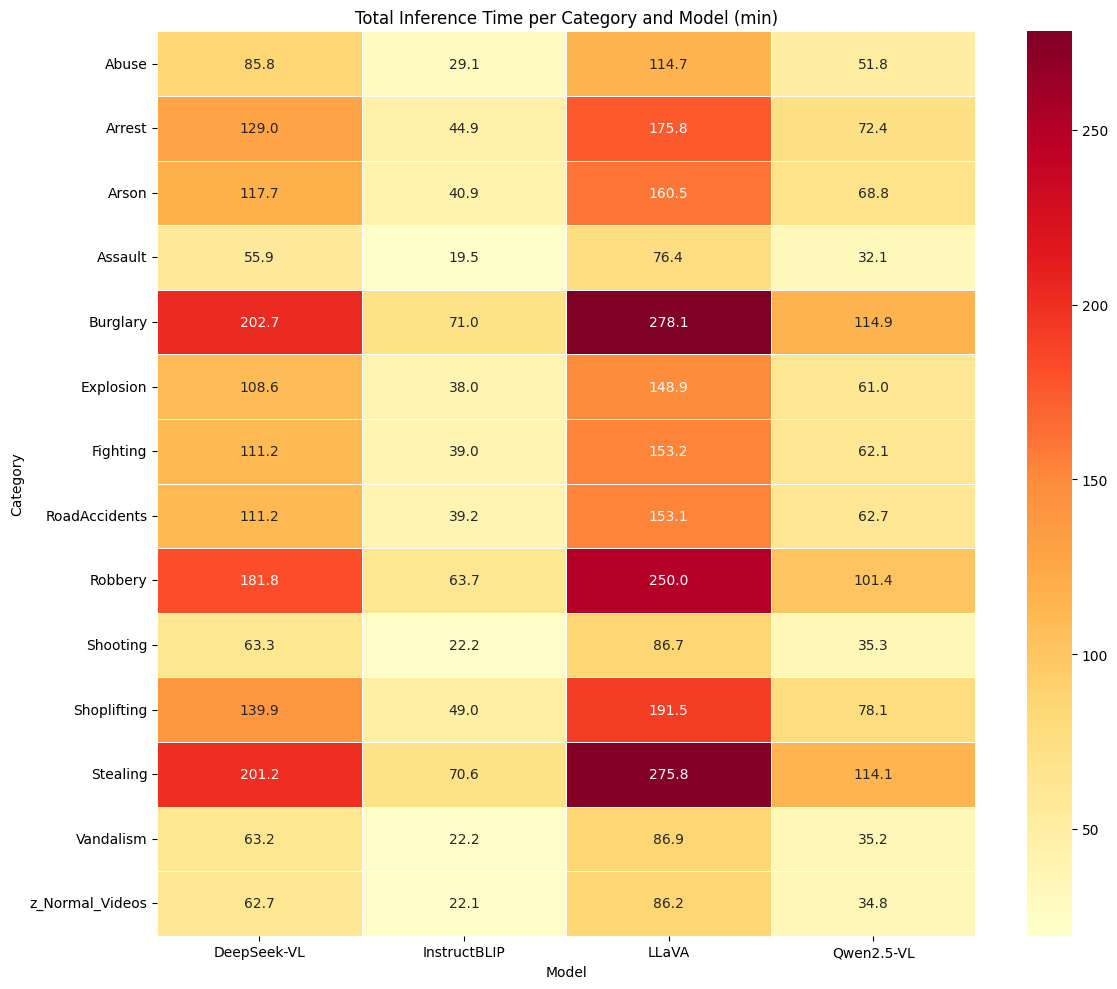

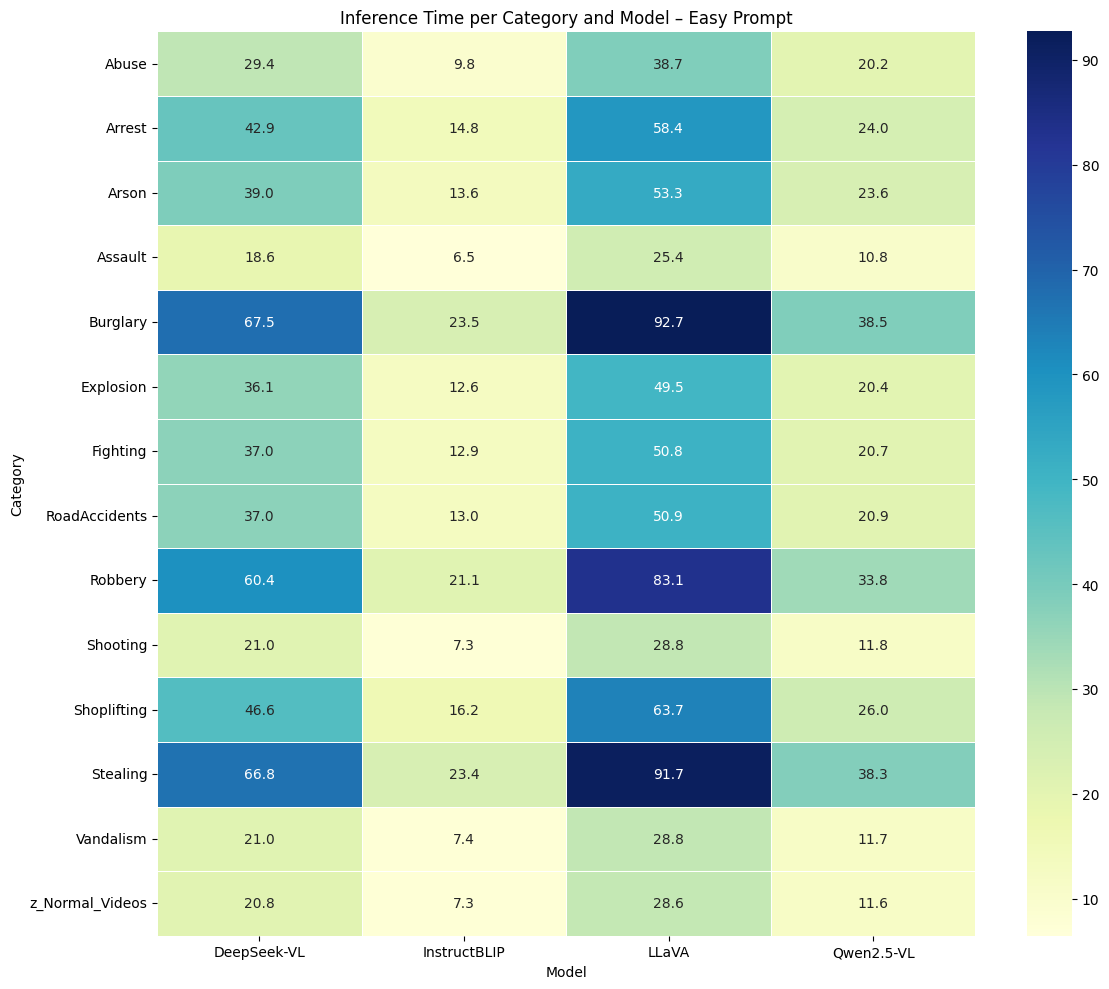

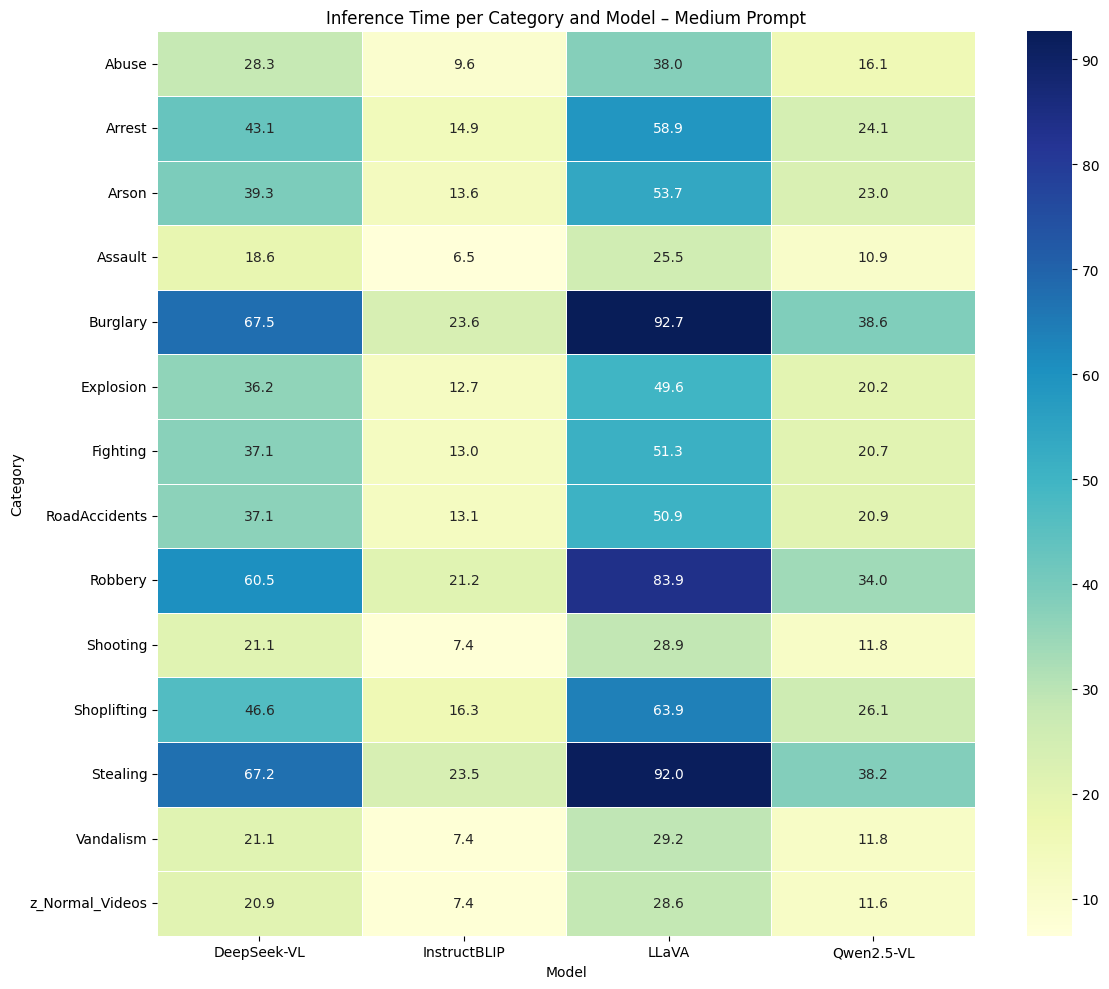

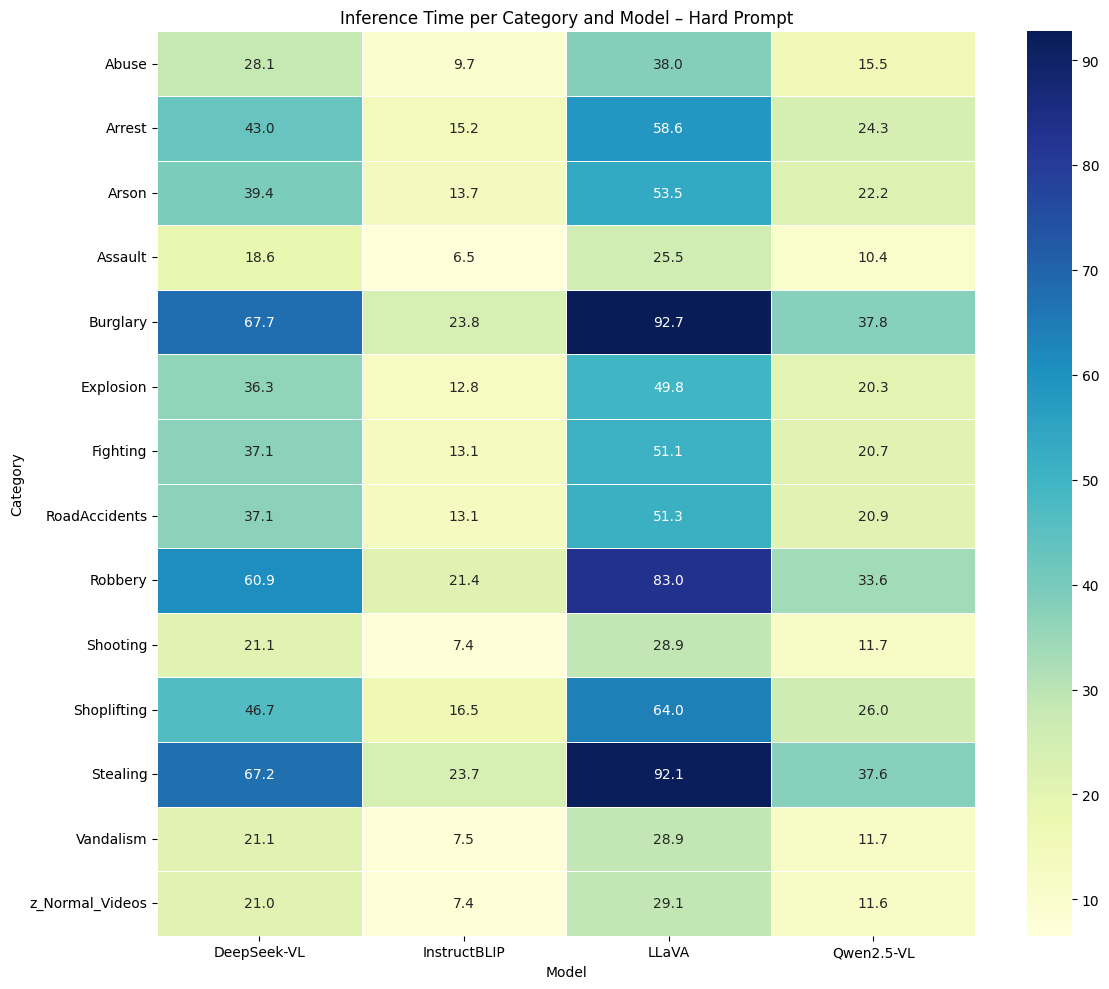

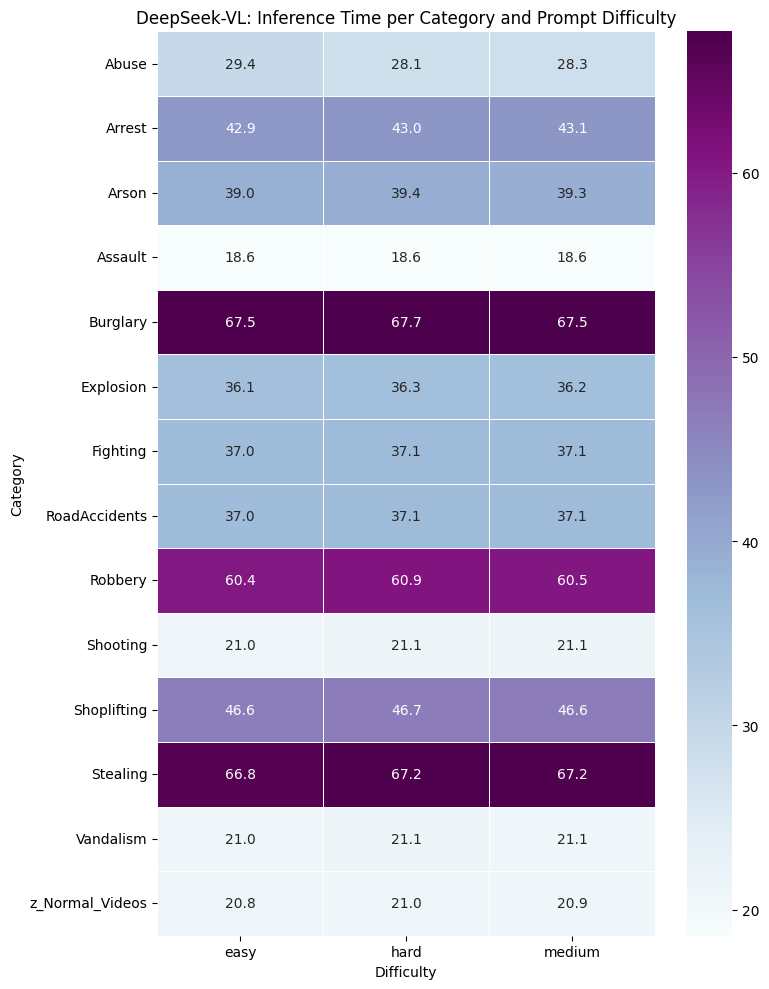

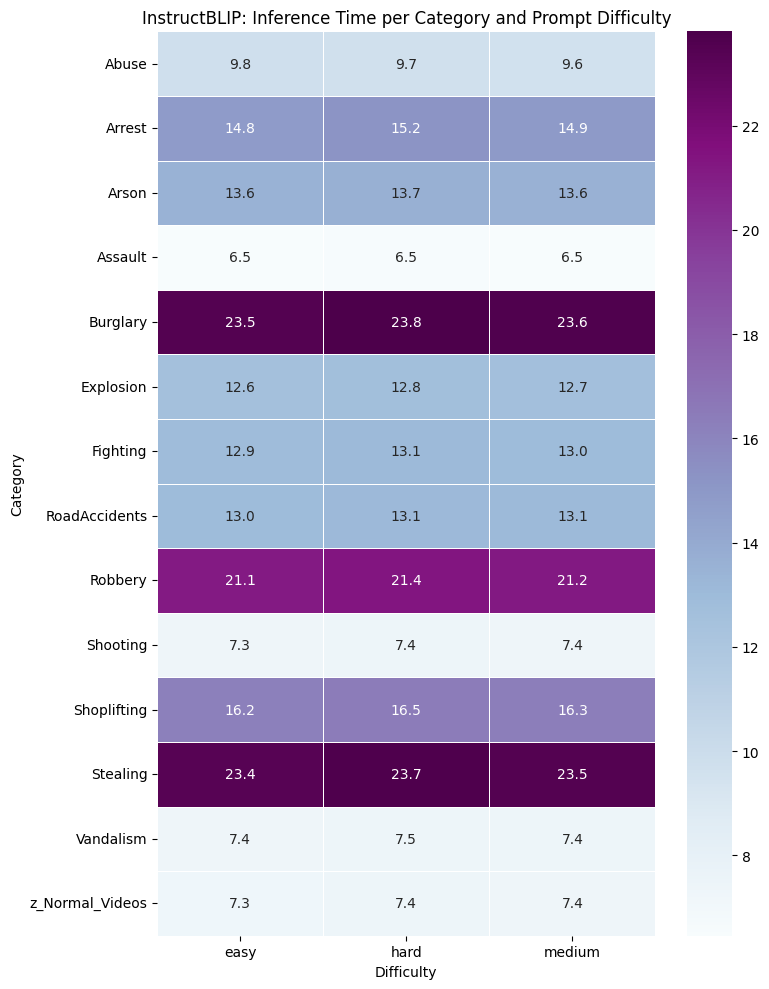

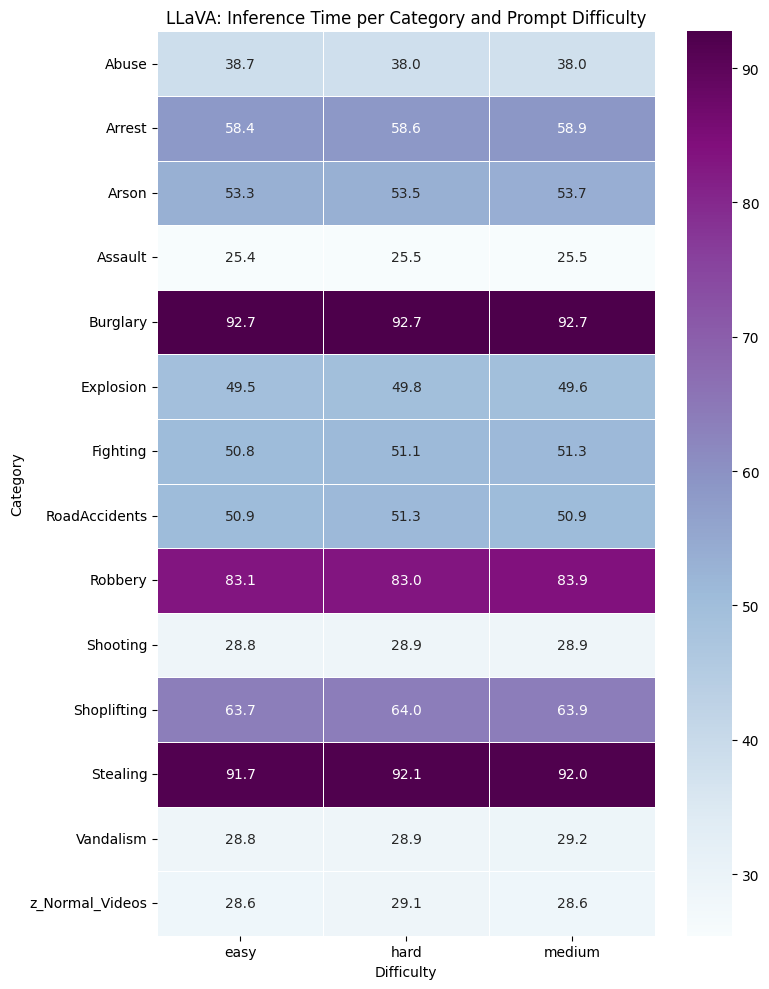

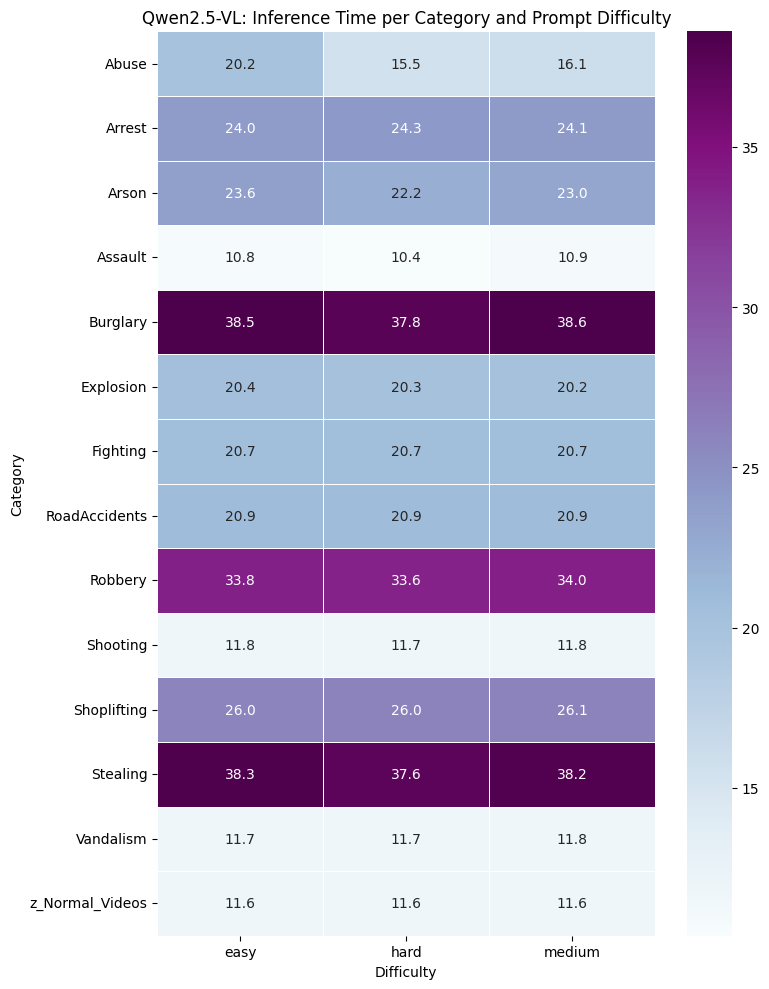

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your CSV
df = pd.read_csv("total_inference_times.csv")

# Clean possible extra whitespace
df["category"] = df["category"].str.strip()
df["Model"] = df["Model"].str.strip()
df["difficulty"] = df["difficulty"].str.strip()

# ========== HEATMAP 1: Total Time per Model and Category ==========
total_time = (
    df.groupby(["category", "Model"])["Inference Time (minutes)"]
    .sum()
    .unstack()
)

plt.figure(figsize=(12, 10))
sns.heatmap(total_time, annot=True, fmt=".1f", cmap="YlOrRd", linewidths=0.5)
plt.title("Total Inference Time per Category and Model (min)")
plt.ylabel("Category")
plt.xlabel("Model")
plt.tight_layout()
plt.savefig("heatmap_total_time_per_model.pdf")
plt.show()


# ========== HEATMAP 2: One per difficulty level ==========
for difficulty in ["easy", "medium", "hard"]:
    df_diff = df[df["difficulty"] == difficulty]
    matrix = (
        df_diff.groupby(["category", "Model"])["Inference Time (minutes)"]
        .sum()
        .unstack()
    )

    plt.figure(figsize=(12, 10))
    sns.heatmap(matrix, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=0.5)
    plt.title(f"Inference Time per Category and Model – {difficulty.capitalize()} Prompt")
    plt.ylabel("Category")
    plt.xlabel("Model")
    plt.tight_layout()
    plt.savefig(f"heatmap_{difficulty}_time.pdf")
    plt.show()


# ========== HEATMAP 3: One per model (Category vs Difficulty) ==========
for model in df["Model"].unique():
    df_model = df[df["Model"] == model]
    matrix = (
        df_model.groupby(["category", "difficulty"])["Inference Time (minutes)"]
        .sum()
        .unstack()
    )

    plt.figure(figsize=(8, 10))
    sns.heatmap(matrix, annot=True, fmt=".1f", cmap="BuPu", linewidths=0.5)
    plt.title(f"{model}: Inference Time per Category and Prompt Difficulty")
    plt.ylabel("Category")
    plt.xlabel("Difficulty")
    plt.tight_layout()
    clean_name = model.replace(" ", "_").replace("-", "").replace(".", "")
    plt.savefig(f"heatmap_{clean_name}_category_difficulty.pdf")
    plt.show()

# Let's analyse the yes we got

In [4]:
import pandas as pd

# Load dataset
df = pd.read_csv("dataset_results.csv")

# Filter valid responses
df["is_yes"] = df["Response"].str.strip().str.lower() == "yes"

# Group by granularity
grouped = df.groupby(["Model", "category", "difficulty", "video_id"])

summary_rows = []

for group_keys, group_df in grouped:
    model, category, difficulty, video_id = group_keys

    total_frames = len(group_df)
    yes_df = group_df[group_df["is_yes"]]

    has_detection = len(yes_df) > 0
    detection_rate = len(yes_df) / total_frames if total_frames > 0 else 0.0

    top_confidences = (
        yes_df.sort_values(by="Confidence", ascending=False)["Confidence"]
        .head(10)
        .tolist()
    )

    summary_rows.append({
        "Model": model,
        "Category": category,
        "Difficulty": difficulty,
        "Video ID": video_id,
        "Frames": total_frames,
        "Yes Count": len(yes_df),
        "Detection Rate": round(detection_rate, 4),
        "Has Detection": has_detection,
        "Top 10 Yes Confidences": top_confidences
    })

# Final summary DataFrame
summary_df = pd.DataFrame(summary_rows)

# Save to CSV for later inspection
summary_df.to_csv("detection_summary.csv", index=False)

print(f"Saved summary for {len(summary_df)} videos to 'detection_summary.csv'")

Saved summary for 12000 videos to 'detection_summary.csv'


In [2]:
import pandas as pd

# Load the detection summary dataset
df = pd.read_csv("detection_summary.csv")

# Ensure correct types
df["Has Detection"] = df["Has Detection"].astype(bool)

# Group and compute metrics
agg = (
    df.groupby(["Model", "Difficulty", "Category"])
    .agg(
        Total_Videos=("Video ID", "count"),
        Detected_Videos=("Has Detection", "sum"),
        Mean_Detection_Rate=("Detection Rate", "mean"),
        Min_Detection_Rate=("Detection Rate", "min"),
        Max_Detection_Rate=("Detection Rate", "max")
    )
    .reset_index()
)

# Add detection coverage in percent
agg["Detection Coverage (%)"] = (agg["Detected_Videos"] / agg["Total_Videos"] * 100).round(2)
agg["Mean_Detection_Rate"] = agg["Mean_Detection_Rate"].round(4)
agg["Min_Detection_Rate"] = agg["Min_Detection_Rate"].round(4)
agg["Max_Detection_Rate"] = agg["Max_Detection_Rate"].round(4)

# Sort for readability
agg.sort_values(by=["Model", "Difficulty", "Category"], inplace=True)

# Save or inspect
agg.to_csv("aggregate_detection.csv", index=False)
print(agg.head(10))  # Preview

         Model Difficulty       Category  Total_Videos  Detected_Videos  \
0  DeepSeek-VL       easy          Abuse            50               48   
1  DeepSeek-VL       easy         Arrest            50               50   
2  DeepSeek-VL       easy          Arson            50               47   
3  DeepSeek-VL       easy        Assault            50               46   
4  DeepSeek-VL       easy       Burglary           100               90   
5  DeepSeek-VL       easy      Explosion            50               46   
6  DeepSeek-VL       easy       Fighting            50               50   
7  DeepSeek-VL       easy  RoadAccidents           150              131   
8  DeepSeek-VL       easy        Robbery           150              150   
9  DeepSeek-VL       easy       Shooting            50               27   

   Mean_Detection_Rate  Min_Detection_Rate  Max_Detection_Rate  \
0               0.7069              0.0000              1.0000   
1               0.5686              0.0506

In [5]:
import pandas as pd

# Load the detection summary dataset
df = pd.read_csv("detection_summary.csv")

# Ensure correct types
df["Has Detection"] = df["Has Detection"].astype(bool)

# Group and compute metrics
agg = (
    df.groupby(["Model", "Difficulty", "Category"])
    .agg(
        Total_Videos=("Video ID", "count"),
        Detected_Videos=("Has Detection", "sum"),
        Mean_Detection_Rate=("Detection Rate", "mean"),
        Min_Detection_Rate=("Detection Rate", "min"),
        Max_Detection_Rate=("Detection Rate", "max")
    )
    .reset_index()
)

# Add detection coverage in percent
agg["Detection Coverage (%)"] = (agg["Detected_Videos"] / agg["Total_Videos"] * 100).round(2)
agg["Mean_Detection_Rate"] = agg["Mean_Detection_Rate"].round(4)
agg["Min_Detection_Rate"] = agg["Min_Detection_Rate"].round(4)
agg["Max_Detection_Rate"] = agg["Max_Detection_Rate"].round(4)

# Sort for readability
agg.sort_values(by=["Model", "Difficulty", "Category"], inplace=True)

# Save or inspect
agg.to_csv("aggregate_detection_summary.csv", index=False)
print(agg.head(10))  # Preview

         Model Difficulty       Category  Total_Videos  Detected_Videos  \
0  DeepSeek-VL       easy          Abuse            50               48   
1  DeepSeek-VL       easy         Arrest            50               50   
2  DeepSeek-VL       easy          Arson            50               47   
3  DeepSeek-VL       easy        Assault            50               46   
4  DeepSeek-VL       easy       Burglary           100               90   
5  DeepSeek-VL       easy      Explosion            50               46   
6  DeepSeek-VL       easy       Fighting            50               50   
7  DeepSeek-VL       easy  RoadAccidents           150              131   
8  DeepSeek-VL       easy        Robbery           150              150   
9  DeepSeek-VL       easy       Shooting            50               27   

   Mean_Detection_Rate  Min_Detection_Rate  Max_Detection_Rate  \
0               0.7069              0.0000              1.0000   
1               0.5686              0.0506

In [4]:
import pandas as pd

df = pd.read_csv("aggregate_detection.csv")
df.columns = [c.strip().replace(" ", "_") for c in df.columns]

# Sort and display full table
df = df.sort_values(by=["Model", "Difficulty", "Category"])
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

display(df)

,Model,Difficulty,Category,Total_Videos,Detected_Videos,Mean_Detection_Rate,Min_Detection_Rate,Max_Detection_Rate,Detection_Coverage_(%)
0,DeepSeek-VL,easy,Abuse,50,48,0.7069,0.0000,1.0000,96.00
1,DeepSeek-VL,easy,Arrest,50,50,0.5686,0.0506,1.0000,100.00
2,DeepSeek-VL,easy,Arson,50,47,0.1878,0.0000,0.7727,94.00
3,DeepSeek-VL,easy,Assault,50,46,0.4660,0.0000,1.0000,92.00
4,DeepSeek-VL,easy,Burglary,100,90,0.3955,0.0000,1.0000,90.00
5,DeepSeek-VL,easy,Explosion,50,46,0.3789,0.0000,0.9917,92.00
6,DeepSeek-VL,easy,Fighting,50,50,0.4116,0.0096,0.9688,100.00
7,DeepSeek-VL,easy,RoadAccidents,150,131,0.4197,0.0000,1.0000,87.33
8,DeepSeek-VL,easy,Robbery,150,150,0.5583,0.0172,1.0000,100.00
9,DeepSeek-VL,easy,Shooting,50,27,0.0313,0.0000,0.2542,54.00


In [4]:
import pandas as pd

# Load the dataset
df = pd.read_csv("aggregate_detection_summary.csv")

# Filter out the 'normal' videos
df = df[df["Category"] != "z_Normal_Videos"]

# Compute per-model, per-category averages
table1 = (
    df.groupby(["Model", "Category"])
    .agg({
        "Detection Coverage (%)": "mean",
        "Mean_Detection_Rate": "mean"
    })
    .round(2)
    .reset_index()
)

# Optional: Display as pivot for better readability
pivot_table1 = table1.pivot(index="Category", columns="Model", values="Detection Coverage (%)")
print(table1)

           Model       Category  Detection Coverage (%)  Mean_Detection_Rate
0    DeepSeek-VL          Abuse                   98.67                 0.84
1    DeepSeek-VL         Arrest                  100.00                 0.70
2    DeepSeek-VL          Arson                   96.67                 0.41
3    DeepSeek-VL        Assault                   96.67                 0.62
4    DeepSeek-VL       Burglary                   95.33                 0.61
5    DeepSeek-VL      Explosion                   96.00                 0.43
6    DeepSeek-VL       Fighting                  100.00                 0.61
7    DeepSeek-VL  RoadAccidents                   93.33                 0.64
8    DeepSeek-VL        Robbery                   99.78                 0.74
9    DeepSeek-VL       Shooting                   71.33                 0.21
10   DeepSeek-VL    Shoplifting                   98.00                 0.81
11   DeepSeek-VL       Stealing                   97.33                 0.64

In [6]:
# Compute per-model global average across all categories
table2 = (
    df.groupby("Model")
    .agg({
        "Detection Coverage (%)": "mean",
        "Mean_Detection_Rate": "mean"
    })
    .round(2)
    .reset_index()
)

print(table2)

          Model  Detection Coverage (%)  Mean_Detection_Rate
0   DeepSeek-VL                   95.62                 0.62
1  InstructBLIP                   99.08                 0.83
2         LLaVA                   74.06                 0.27
3    Qwen2.5-VL                   66.90                 0.16
